Model: "model_94"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_148 (InputLayer)       [(None, 8, 8, 216)]       0         
_________________________________________________________________
conv2d_211 (Conv2D)          (None, 8, 8, 512)         111104    
_________________________________________________________________
conv2d_212 (Conv2D)          (None, 8, 8, 8)           4104      
Total params: 115,208
Trainable params: 115,208
Non-trainable params: 0
_________________________________________________________________
Target:


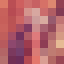

Sample run:


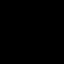

Training...
Target:


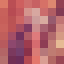

Sample run:


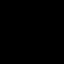


 step: 34, log10(loss): -0.442

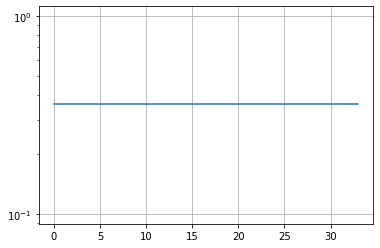

Training...
Target:


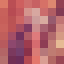

Sample run:


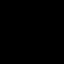


 step: 142, log10(loss): -0.442

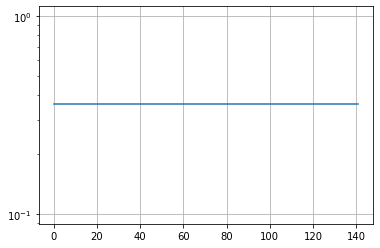

Training...
Target:


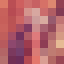

Sample run:


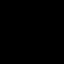


 step: 261, log10(loss): -0.442

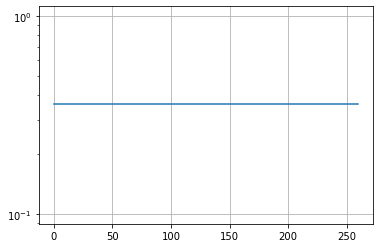

Training...
Target:


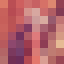

Sample run:


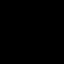


 step: 367, log10(loss): -0.442

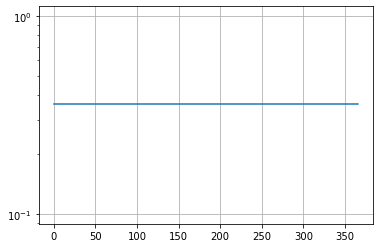

Training...
Target:


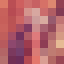

Sample run:


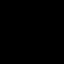


 step: 461, log10(loss): -0.442

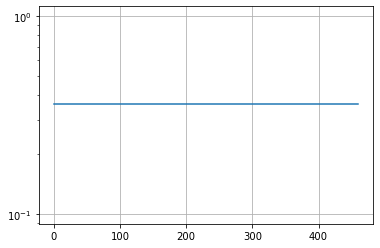

Training...
Target:


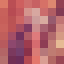

Sample run:


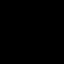


 step: 558, log10(loss): -0.442

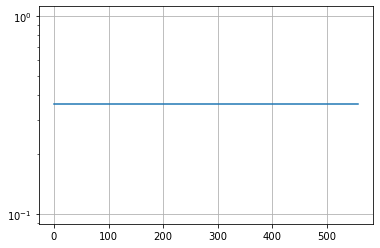

Training...
Target:


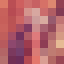

Sample run:


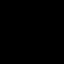


 step: 678, log10(loss): -0.442

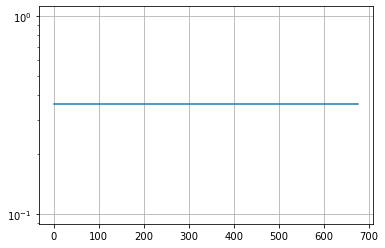

Training...
Target:


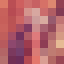

Sample run:


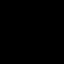


 step: 796, log10(loss): -0.442

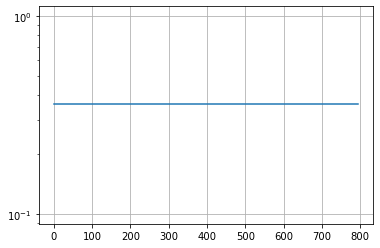

Training...
Target:


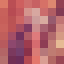

Sample run:


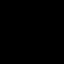


 step: 904, log10(loss): -0.442

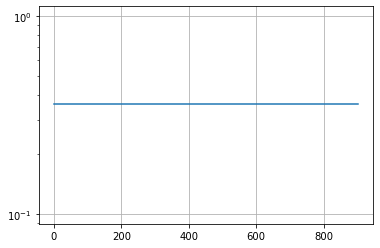

Training...
Target:


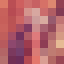

Sample run:


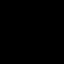


 step: 1014, log10(loss): -0.442

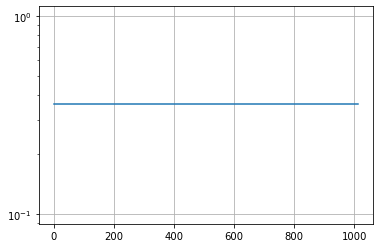

Training...
Target:


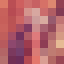

Sample run:


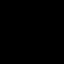


 step: 1129, log10(loss): -0.442

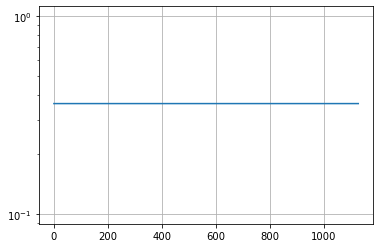

Training...
Target:


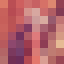

Sample run:


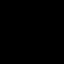


 step: 1249, log10(loss): -0.442

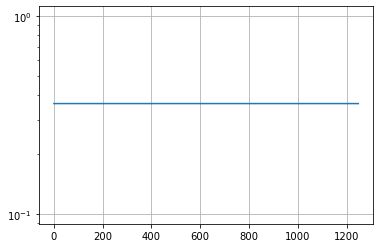

Training...
Target:


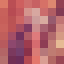

Sample run:


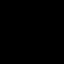


 step: 1360, log10(loss): -0.442

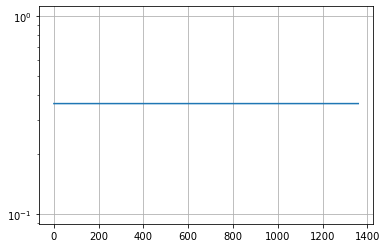

Training...
Target:


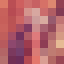

Sample run:


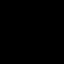


 step: 1461, log10(loss): -0.442

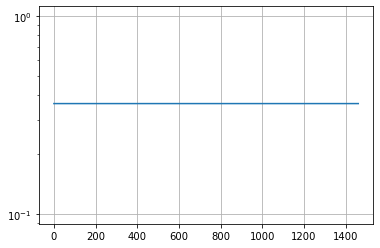

Training...
Target:


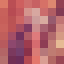

Sample run:


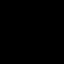


 step: 1561, log10(loss): -0.442

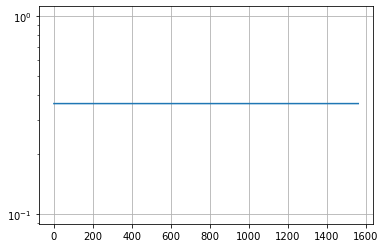

Training...
Target:


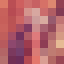

Sample run:


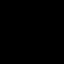


 step: 1656, log10(loss): -0.442

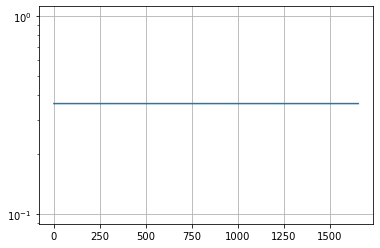

Training...
Target:


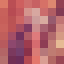

Sample run:


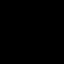


 step: 1743, log10(loss): -0.442

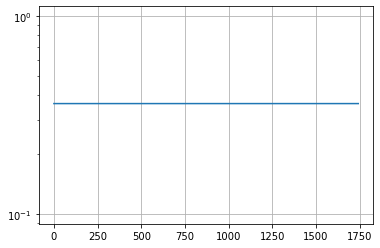

Training...
Target:


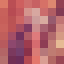

Sample run:


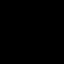


 step: 1846, log10(loss): -0.442

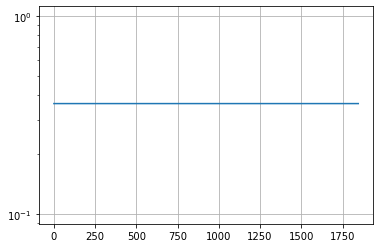

Training...
Target:


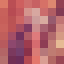

Sample run:


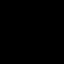


 step: 1949, log10(loss): -0.442

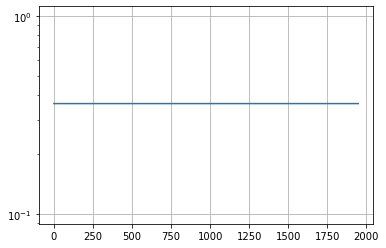

Training...
Target:


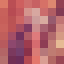

Sample run:


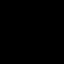


 step: 2070, log10(loss): -0.442

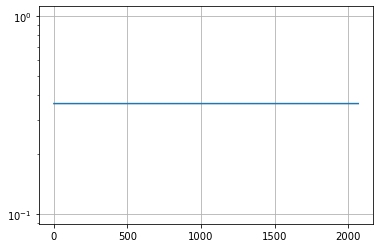

saved


In [105]:
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import PIL.Image
import IPython.display
import io
import random
import time
import statistics as stats
from matplotlib import pyplot as plt

class CellularAutomata(tf.keras.Model):
    def __init__(self, img_size: int, channel_count: int, layers: [int], perception_kernel):
        super().__init__()
        
        self.img_size = img_size
        self.channel_count = channel_count
        self.conserve_mass = False
        self.noise = 0.0
        self.clamp_values = True

        perception_input = tf.keras.layers.Input(shape=(img_size, img_size, channel_count * 3 + img_size * img_size * 3))
        curr_layer = perception_input
        for layer_size in layers:
            curr_layer = tf.keras.layers.Conv2D(filters=layer_size, kernel_size=1, activation=tf.nn.relu)(curr_layer)
        output_layer = tf.keras.layers.Conv2D(filters=channel_count, kernel_size=1, activation=None)(curr_layer)
        
        self.model = tf.keras.Model(inputs=[perception_input], outputs=output_layer)
        
        # Project the perception tensor so that it is 4D. This is used by the depthwise convolution
        # to create a dot product along the 3rd axis, but we don't need that so we index
        # it with None:
        perception_kernel = perception_kernel[:, :, None, :]
        perception_kernel = tf.repeat(perception_kernel, 
            repeats=self.channel_count, 
            axis=2)
        self.perception_kernel = perception_kernel
        
    @tf.function
    def perceive(self, x, target):
        conv = tf.nn.depthwise_conv2d(x, 
            filter=self.perception_kernel, 
            strides=[1, 1, 1, 1],
            padding="SAME")
        
        flattened_target = tf.reshape(target, shape=(self.img_size * self.img_size * 3,))
        repeated = tf.broadcast_to(input=flattened_target, shape=[1, self.img_size, self.img_size, self.img_size * self.img_size * 3])
        conv_with_target = tf.concat([conv, repeated], axis=-1)
        return conv_with_target
    
    @tf.function
    def call(self, x, target):
        s = self.perceive(x, target)
        dx = self.model(s)
        
        # Add mass conservation to the model by subtracting the average of the dx values.
        if self.conserve_mass:
            dx -= tf.math.reduce_mean(dx)
        x += dx
        
        # Add random noise.
        x += (tf.cast(tf.random.uniform(tf.shape(x[:, :, :, :])), tf.float32) - 0.5) * 2.0 * self.noise
        
        # Keep random noise or changes in dx from causing out-of-range values.
        if self.clamp_values:
            x = tf.clip_by_value(x, 0.0, 1.0)
            
        return x

    def imagefilled(self, image_path):
        """ Fills the world with image data from the disk. """
        x = self.zerofilled()
        img = PIL.Image.open(image_path).convert("RGB")
        img = img.resize(size=(self.img_size, self.img_size))
        color_arr = np.float32(img) / 255.0
        x[:, :, :3] = color_arr
        return x

    def zerofilled(self):
        """ Fills the world with zeros. """
        return np.zeros((self.img_size, self.img_size, self.channel_count), dtype=np.float32)

    def onefilled(self):
        """ Fills the world with ones. """
        return np.ones((self.img_size, self.img_size, self.channel_count), dtype=np.float32)
        
    def pointfilled(self):
        """ Fills the world with zeros except for a single point. """
        x = np.zeros((self.img_size, self.img_size, self.channel_count), dtype=np.float32)
        x[self.img_size // 2, self.img_size // 2] = np.ones((self.channel_count,))
        return x
    
    def randomfilled(self):
        """ Fills the world with random numbers from 0 to the random fill maximum. """
        x = np.random.rand(self.img_size, self.img_size, self.channel_count).astype(np.float32)
        return x
        
    def to_image(self, x, scale=1):
        # Slice off all the non-color (hidden channels):
        arr = x[..., :3]
        rgb_array = np.uint8(arr * 255.0)

        # Scale the first two dimensions of the image by the given scale.
        for dim in range(2):
            rgb_array = np.repeat(rgb_array, scale, dim)

        out = io.BytesIO()
        return PIL.Image.fromarray(rgb_array)
        PIL.Image.fromarray(rgb_array).save(out, 'png')
        return IPython.display.Image(data=out.getvalue())
    
    def display_gif(self, xs, scale=None):
        if scale is None:
            scale = 64 // self.img_size
            
        out = io.BytesIO()
        imgs = [self.to_image(x, scale) for x in xs]
        durs = [100 for img in imgs]
        durs[0] = 1000
        durs[-1] = 1000
        imgs[0].save(out, 'gif', save_all=True, append_images=imgs[1:], loop=0, duration=durs)
        img = IPython.display.Image(data=out.getvalue())
        IPython.display.display(img)

    def display(self, x, scale=None):
        if scale is None:
            scale = 64 // self.img_size
            
        out = io.BytesIO()
        self.to_image(x, scale).save(out, 'png')
        img = IPython.display.Image(data=out.getvalue())
        IPython.display.display(img)
        
class Training(object):
    def __init__(self, ca, learning_rate):
        self.ca = ca
        self.loss_hist = []
        self.learning_rate = learning_rate
        self.lr_sched = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
            boundaries = [2000], 
            values = [self.learning_rate, self.learning_rate * 0.1])
        self.trainer = tf.keras.optimizers.Adam(self.lr_sched)
        
    def get_loss(self, x, target):
        return tf.reduce_mean(tf.square(x[..., :3] - target))
    
    def get_sum(self, x):
        return tf.reduce_sum(x)
    
    @tf.function
    def train_step(self, x, target, lifetime):
        target = target[..., :3]
        with tf.GradientTape() as g:
            for i in tf.range(lifetime):
                x = self.ca(x, target)
            loss = tf.reduce_mean(self.get_loss(x, target))
            
        grads = g.gradient(loss, self.ca.weights)
        grads = [g / (tf.norm(g) + 1.0e-8) for g in grads]
        self.trainer.apply_gradients(zip(grads, self.ca.weights))
        return x, loss
    
    def show_sample_run(self, x0, target, lifetime):
        print("Target:")
        self.ca.display(target)
        
        # Run the CA for its lifetime with the current weights.
        x = x0[None, ...]
        target = target[..., :3]
            
        xs = []
        for i in range(lifetime):
            xs.append(x[0, ..., :3])
            x = self.ca(x, target)
        xs.append(x[0, ..., :3])

        print("Sample run:")
        self.ca.display_gif(xs)
        
    def show_loss_history(self):
        if self.loss_hist:
            print("\n step: %d, log10(loss): %.3f" % (
                len(self.loss_hist), np.log10(self.loss_hist[-1])), end='')
            plt.plot(self.loss_hist)
            plt.yscale('log')
            plt.grid()
            plt.show()
    
    def run(self, x0, target, lifetime, seconds=5):
        initial = result = loss = None
        start = time.time()
        elapsed_seconds = 0.0
        while elapsed_seconds < seconds:
            initial = np.repeat(x0[None, ...], 1, 0)
            x, loss = self.train_step(initial, target, lifetime)
            self.loss_hist.append(loss.numpy())
            
            # Feed the final state back in and train again on that.
            #x, loss = self.train_step(x, target, lifetime)
            
            elapsed_seconds = time.time() - start
            
    def save(self):
        self.ca.model.save_weights("./checkpoints/data")
        
    def save_exists(self):
        return os.path.isdir("./checkpoints")
        
    def load(self):
        self.ca.model.load_weights("./checkpoints/data")
        
def sobel_state_kernel():
    # Create a Sobel filter:
    identity = np.float32([0, 1, 0])
    identity = np.outer(identity, identity)
    dx = np.outer(np.float32([1, 2, 1]), np.float32([-1, 0, 1])) / 8.0
    dy = dx.T
    return tf.stack([identity, dx - dy, dx + dy], axis=-1)

def tensor_basis_kernel():
    basis = []
    for x in range(3):
        for y in range(3):
            tensor = np.zeros((3, 3), dtype=np.float32)
            tensor[x, y] = 1
            basis.append(tensor)
    return tf.stack(basis, axis=-1)

def build_configuration(do_load=True):
    ca = CellularAutomata(img_size=8, channel_count=8, layers=[512], perception_kernel=sobel_state_kernel())
    ca.noise = 0.0
    ca.model.summary()

    training = Training(ca=ca, learning_rate=1.0e-3)
    if training.save_exists() and do_load:
        training.load()
        print("loaded")
    
    return ca, training

ca, training = build_configuration(do_load=False)
x0 = ca.zerofilled()

target_filenames = ["checkers8.png", "earth16.png", "guided_square8.png", "lenna32.png", "mandelbrot64.png", "microbe32.png", "square8.png"]
targets = [ca.imagefilled(filename) for filename in target_filenames]

target = targets[3]

training.show_sample_run(x0, target, lifetime=10)

for i in range(1):
    print("Training...")
    training.run(x0, target, lifetime=10, seconds=5)

    training.show_sample_run(x0, target, lifetime=10)

    training.show_loss_history()
    training.save()

print("saved")

In [ ]:
ca, training = build_configuration()

x0 = ca.zerofilled()
target = ca.imagefilled("earth16.png")
lifetime = 10

training.show_sample_run(x0, target, lifetime)